In [67]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize_scalar
from scipy.stats import beta as beta_dist
from scipy.stats import truncnorm
from numpy.polynomial.legendre import leggauss

In [3]:
# useful utility function
def make_utility(name: str, **kwargs):
    """
    Returns a utility function U(w) as a callable.

    Supported:
      - name="cara", a>0: U(w) = -exp(-a w)
      - name="log": U(w) = log(w)   (requires w>0)
      - name="crra", gamma!=1: U(w) = w^(1-gamma)/(1-gamma)
    """
    name = name.lower()

    if name == "cara":
        a = float(kwargs.get("a", 1.0))
        if a <= 0:
            raise ValueError("CARA requires a>0.")
        return lambda w: -np.exp(-a * w)

    if name == "log":
        return lambda w: np.log(w)

    if name == "crra":
        gamma = float(kwargs.get("gamma", 2.0))
        if np.isclose(gamma, 1.0):
            raise ValueError("Use log utility for gamma=1.")
        return lambda w: (np.power(w, 1.0 - gamma) / (1.0 - gamma))

    raise ValueError(f"Unknown utility name: {name}")


In [4]:
# Construct Beta(alpha,beta) from mean and variance.
def beta_from_mean_var(mu: float, var: float):
    """
    Construct Beta(alpha,beta) from mean and variance.
    """
    if not (0 < mu < 1):
        raise ValueError("mu must be in (0,1).")
    max_var = mu * (1.0 - mu)
    if not (0 < var < max_var):
        raise ValueError(f"var must be in (0, mu(1-mu)) = (0, {max_var}).")

    k = mu * (1.0 - mu) / var - 1.0
    alpha = mu * k
    beta = (1.0 - mu) * k
    return alpha, beta

In [38]:
# draw \delta from some distribution
def draw_delta(dist_name: str, n: int, rng: np.random.Generator, para=None):
    """
    Draw delta ~ F supported on [0,1].

    Parameters
    ----------
    dist_name : {"beta_mv", "beta_ab", "truncnorm"}
      - "beta_mv": theta = (mu, var)
      - "beta_ab" : theta = (alpha, beta)
      - "truncnorm": theta = (mu, sigma) for underlying normal, truncated to [0,1]
    n : int
    rng : np.random.Generator
    para : tuple/list/np.ndarray
      Parameter vector for the chosen distribution.

    Returns
    -------
    deltas : np.ndarray
    info : dict  (mean, var)
    """
    name = dist_name.lower()
    if para is None:
        raise ValueError("Provide theta as a tuple/list/array; see docstring.")

    if name == "beta_mv":
        mu, var = float(para[0]), float(para[1])
        a, b = beta_from_mean_var(mu, var)
        deltas = beta_dist.rvs(a, b, size=n, random_state=rng)
        info = {"mean": mu, "var": var}
        return np.clip(deltas, 0.0, 1.0), info

    if name == "beta_ab":
        a, b = float(para[0]), float(para[1])
        if a <= 0 or b <= 0:
            raise ValueError("Beta requires alpha>0 and beta>0.")
        deltas = beta_dist.rvs(a, b, size=n, random_state=rng)
        info = {"mean": round(a / (a + b),4), 
                "var": round((a * b) / (((a + b) ** 2) * (a + b + 1)),4)}
        return np.clip(deltas, 0.0, 1.0), info

    if name == "truncnorm":
        mu, sigma = float(para[0]), float(para[1])
        if sigma <= 0:
            raise ValueError("truncnorm requires sigma>0.")
        a = (0.0 - mu) / sigma
        b = (1.0 - mu) / sigma
        dist = truncnorm(a, b, loc=mu, scale=sigma)
        deltas = dist.rvs(size=n, random_state=rng)
        info = {"mean": float(dist.mean()), "var": float(dist.var())}
        return np.clip(deltas, 0.0, 1.0), info

    raise ValueError(f"Unknown dist_name: {dist_name}")

In [6]:
# p(\delta^*) from the zero-profit constraint
def premium_mc(delta_star: float, V: float, deltas: np.ndarray) -> float:
    """
    Actuarially fair premium under the contract:
      p(delta*) = V * E[ delta * 1{delta >= delta*} ].
    """
    d = deltas
    return V * float(np.mean(d * (d >= delta_star)))

In [7]:
# calculate expected utility with exogenous parts given
def expected_utility_mc(delta_star: float, U, V: float, y: float, deltas: np.ndarray) -> float:
    """
    Expected utility with p(delta*) imposed (zero profit).
    Wealth:
      if delta < delta*:  W = y - p + V - delta V
      if delta >= delta*: W = y - p + V
    """
    d = deltas
    p = premium_mc(delta_star, V, d)

    W = np.empty_like(d)
    m = (d < delta_star)
    W[m] = y - p + V - d[m] * V
    W[~m] = y - p + V

    return float(np.mean(U(W)))

In [8]:
def solve_delta_star(U, V: float, y: float, deltas: np.ndarray):
    """
    Numerically maximize EU(delta*) over [0,1] via bounded scalar optimization.
    """
    obj = lambda ds: -expected_utility_mc(ds, U, V, y, deltas)
    res = minimize_scalar(obj, bounds=(0.0, 1.0), method="bounded",
                          options={"xatol": 1e-6, "maxiter": 500})
    ds_opt = float(res.x)
    return {
        "delta_star_opt": ds_opt,
        "p_opt": premium_mc(ds_opt, V, deltas),
        "eu_opt": expected_utility_mc(ds_opt, U, V, y, deltas),
        "success": bool(res.success),
        "nfev": int(res.nfev),
        "message": getattr(res, "message", "")
    }

In [66]:
def solve_delta_star_grid(U, V: float, y: float, deltas: np.ndarray,
                          n_grid: int = 1001):
    """
    Numerically maximize EU(delta*) over [0,1] via grid search.

    Parameters
    ----------
    n_grid : int
        Number of grid points on [0,1].

    Returns
    -------
    dict with the same keys as solve_delta_star.
    """
    # Grid includes endpoints 0 and 1 by construction
    grid = np.linspace(0.0, 1.0, n_grid)

    # Evaluate objective (maximize EU)
    eu_vals = np.empty_like(grid)
    for i, ds in enumerate(grid):
        eu_vals[i] = expected_utility_mc(ds, U, V, y, deltas)

    idx = int(np.argmax(eu_vals))
    ds_opt = float(grid[idx])

    return {
        "delta_star_opt": ds_opt,
        "p_opt": premium_mc(ds_opt, V, deltas),
        "eu_opt": float(eu_vals[idx]),
        "success": True,
        "nfev": int(n_grid),
        "message": f"Grid search over {n_grid} points on [0,1] (endpoints included)."
    }

In [63]:
# Initialize primitives
V = 300_000.0
y = 50_000.0

# Utility
U = make_utility("cara", a=1e-5)
# U = make_utility("log")
# U = make_utility("crra", gamma=3.0)

# Distribution draws
n_mc = 200_000
seed = 17
rng = np.random.default_rng(seed)

# F distribution: Beta on [0,1] via mean and variance
para=(0.2, 0.015)
# para=(0.26, 0.05)
deltas, dist_info = draw_delta("beta_mv", n_mc, rng, para)

# F: Truncated normal on [0,1]
# deltas, dist_info = draw_delta("truncnorm", n_mc, rng, (0.1, 0.2))

print("Dist info:", dist_info)

Dist info: {'mean': 0.2, 'var': 0.015}


In [59]:
# sol = solve_delta_star(U, V, y, deltas)
# print("Solution:", sol)

Solution: {'delta_star_opt': 0.000885508479267118, 'p_opt': 60053.35445036832, 'eu_opt': -0.05505259071098147, 'success': True, 'nfev': 31, 'message': 'Solution found.'}


In [64]:
sol = solve_delta_star_grid(U, V, y, deltas)
print("Solution:", sol)

Solution: {'delta_star_opt': 0.0, 'p_opt': 60053.36440200677, 'eu_opt': -0.05505259070479362, 'success': True, 'nfev': 2001, 'message': 'Grid search over 2001 points on [0,1] (endpoints included).'}


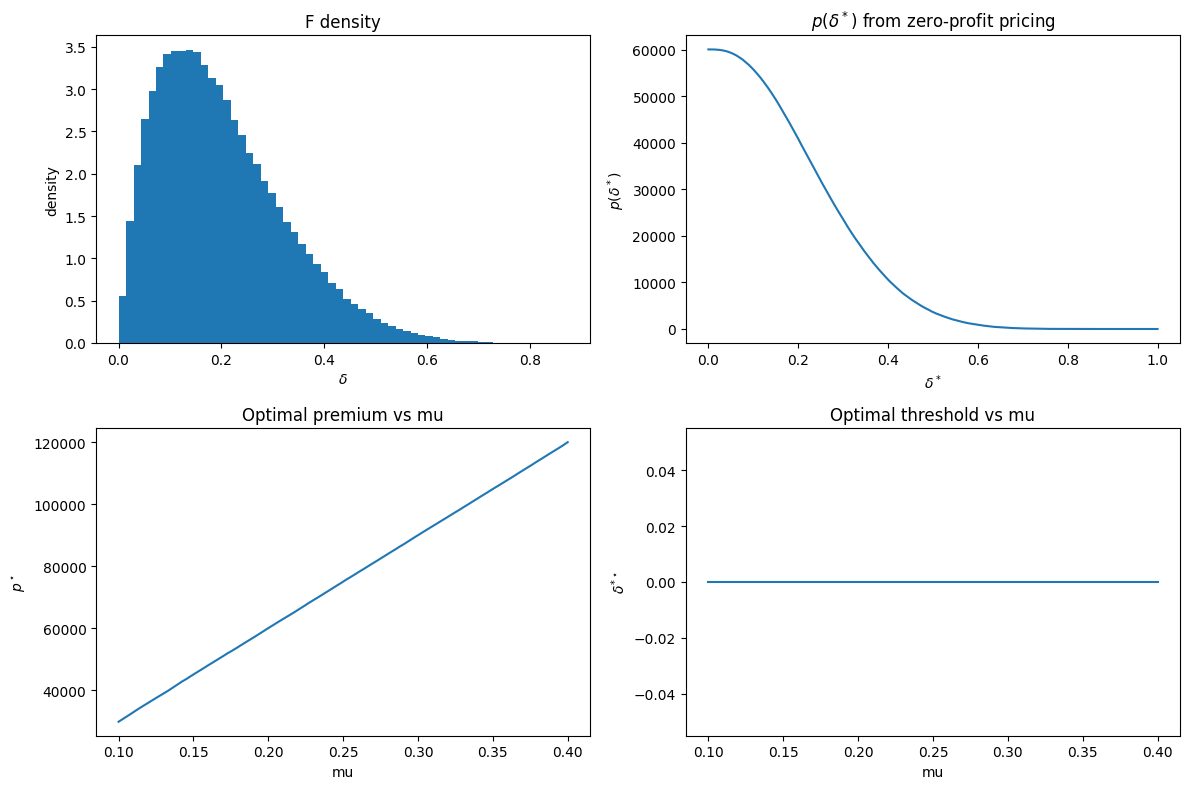

In [69]:
# OUTPUT: print exogenous settings first

# ============================
# 2x2 PANEL PLOT
#   UL: density of F
#   UR: p(delta*) schedule
#   LL: p_opt vs chosen exogenous variable
#   LR: delta*_opt vs chosen exogenous variable
# ============================

# Choose the exogenous variable to sweep (adaptable)
# By default: sweep mu of Beta while holding var fixed
sweep_name = "mu"
x_grid = np.linspace(0.1, 0.4, 100)
var_fixed = 0.015

# Define how to regenerate deltas given x (exogenous variable value).
def gen_deltas_from_x(x):
    rng_local = np.random.default_rng(seed)  # same seed each x for stability
    if sweep_name == "mu":
        return draw_delta("beta_mv", n_mc, rng_local, para = (x, var_fixed))[0]
    # Examples for later:
    # if sweep_name == "V": return deltas 
    # if sweep_name == "y": return deltas
    raise ValueError("Unsupported sweep_name in gen_deltas_from_x; extend as needed.")

# Compute (p_opt, delta*_opt) along the sweep
p_opt_series = np.empty_like(x_grid, dtype=float)
ds_opt_series = np.empty_like(x_grid, dtype=float)

for i, x in enumerate(x_grid):
    deltas_x = gen_deltas_from_x(x)

    # If later sweep V or y, change V_x or y_x here instead of deltas_x.
    V_x = V
    y_x = y

    sol_x = solve_delta_star_grid(U, V_x, y_x, deltas_x)
    # sol_x = solve_delta_star(U, V_x, y_x, deltas_x)
    p_opt_series[i] = sol_x["p_opt"]
    ds_opt_series[i] = sol_x["delta_star_opt"]

# Panel plotting
fig, ax = plt.subplots(2, 2, figsize=(12, 8))

# UL: density plot of F
ax[0, 0].hist(deltas, bins=60, density=True)
ax[0, 0].set_title("F density")
ax[0, 0].set_xlabel(r"$\delta$")
ax[0, 0].set_ylabel("density")

# UR: p(delta*) schedule
ds_grid = np.linspace(0.0, 1.0, 301)
p_sched = np.array([premium_mc(ds, V, deltas) for ds in ds_grid])
ax[0, 1].plot(ds_grid, p_sched)
ax[0, 1].set_title(r"$p(\delta^*)$ from zero-profit pricing")
ax[0, 1].set_xlabel(r"$\delta^*$")
ax[0, 1].set_ylabel(r"$p(\delta^*)$")

# LL: p_opt vs exogenous variable
ax[1, 0].plot(x_grid, p_opt_series)
ax[1, 0].set_title(rf"Optimal premium vs {sweep_name}")
ax[1, 0].set_xlabel(sweep_name)
ax[1, 0].set_ylabel(r"$p^\star$")

# LR: delta*_opt vs exogenous variable
ax[1, 1].plot(x_grid, ds_opt_series)
ax[1, 1].set_title(rf"Optimal threshold vs {sweep_name}")
ax[1, 1].set_xlabel(sweep_name)
ax[1, 1].set_ylabel(r"$\delta^{*\star}$")

plt.tight_layout()
plt.show()